In [0]:
%%capture
!pip install cadCAD

# Modified SEIR on cadCAD

This is an modified SEIR model implementation for didatic purposes by the cadCAD.br people. We've used the model and parameters from the "Epidemic analysis of COVID-19 in China by dynamical modeling" article (https://arxiv.org/pdf/2002.06563.pdf).

Feel free to modify the parameters and blocks.


In [0]:
POPULATION = 8 * 1e6 # Sao Paulo Population

genesis_state = {
    'susceptible_pop': POPULATION, # Human count
    'insusceptible_pop': 0, # Human count
    'exposed_pop': 0, # Human count
    'infective_pop': 100, # Human count
    'quarantined_pop': 0, # Human count
    'recovered_pop': 0, # Human count
    'killed_pop': 0, # Human count
    'cure_rate': 0.97 / 14, # day⁻¹
    'death_rate': 0.03 / 14  # day⁻¹
}

parameters = {
    'protection_rate': 0.08, # Ratio - Percentage of insusceptible people protecting themselves
    'infection_rate': 1.0, # Humans per day - How much other people each infective person infects per day
    'average_latent_time': 2, # Days
    'average_quarantine_time': 7 # Days
}

In [0]:
## Functions

def total_pop(s):
    total = s.get('susceptible_pop', 0)
    total += s.get('insusceptible_pop', 0)
    total += s.get('exposed_pop', 0)
    total += s.get('infective_pop', 0)
    total += s.get('quarantined_pop', 0)
    total += s.get('recovered_pop', 0)
    return total

## Policies

def p_move_people_to_mountains(params, substep, state_history, prev_state):
    delta = params['protection_rate']
    delta *= prev_state['susceptible_pop']
    return {'delta_P': delta,
            'delta_S': -delta}

def p_expose_people(params, substep, state_history, prev_state):
    delta = params['infection_rate']
    delta *= prev_state['susceptible_pop']
    delta *= prev_state['infective_pop']
    delta /= total_pop(prev_state)
    return {'delta_E': delta,
            'delta_S': -delta}


def p_progress_disease(params, substep, state_history, prev_state):
    delta = prev_state['exposed_pop'] / params['average_latent_time']
    return {'delta_E': -delta,
            'delta_I': delta}

def p_quarantine_people(params, substep, state_history, prev_state):
    delta = prev_state['infective_pop'] / params['average_quarantine_time']
    return {'delta_I': -delta,
            'delta_Q': delta}  

def p_recovery(params, substep, state_history, prev_state):
    delta = prev_state['quarantined_pop'] * prev_state['cure_rate']
    return {'delta_R': delta,
            'delta_Q': -delta}  


def p_death(params, substep, state_history, prev_state):
    delta = prev_state['quarantined_pop'] * prev_state['death_rate']
    return {'delta_D': delta,
            'delta_Q': -delta}  


## State Update Functions

def s_susceptible_pop(params, substep, state_history, prev_state, policy_input):
  new_value = prev_state['susceptible_pop'] + policy_input.get('delta_S', 0)
  return ('susceptible_pop', new_value)


def s_insusceptible_pop(params, substep, state_history, prev_state, policy_input):
  new_value = prev_state['insusceptible_pop'] + policy_input.get('delta_P', 0)
  return ('insusceptible_pop', new_value)


def s_exposed_pop(params, substep, state_history, prev_state, policy_input):
  new_value = prev_state['exposed_pop'] + policy_input.get('delta_E', 0)
  return ('exposed_pop', new_value)


def s_infective_pop(params, substep, state_history, prev_state, policy_input):
  new_value = prev_state['infective_pop'] + policy_input.get('delta_I', 0)
  return ('infective_pop', new_value)


def s_quarantine_pop(params, substep, state_history, prev_state, policy_input):
  new_value = prev_state['quarantined_pop'] + policy_input.get('delta_Q', 0)
  return ('quarantined_pop', new_value)


def s_recovered_pop(params, substep, state_history, prev_state, policy_input):
  new_value = prev_state['recovered_pop'] + policy_input.get('delta_R', 0)
  return ('recovered_pop', new_value)


def s_killed_pop(params, substep, state_history, prev_state, policy_input):
  new_value = prev_state['killed_pop'] + policy_input.get('delta_D', 0)
  return ('killed_pop', new_value)

In [0]:
partial_state_update_block = [
  {
      'policies': {
        'move_people_to_mountains': p_move_people_to_mountains,
        'expose_people': p_expose_people,
        'progress_disease': p_progress_disease,
        'quarantine_people': p_quarantine_people,
        'recovery': p_recovery,
        'death': p_death
      },
      'variables': {
        'susceptible_pop': s_susceptible_pop,
        'insusceptible_pop': s_insusceptible_pop,
        'exposed_pop': s_exposed_pop,
        'infective_pop': s_infective_pop,
        'quarantined_pop': s_quarantine_pop,
        'recovered_pop': s_recovered_pop,
        'killed_pop': s_killed_pop
      }
  }
]

In [0]:
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor


sim_config = (
    {
        'N': 1,
        'T': range(90), # number of timesteps
        'M': parameters,
    }
)
config = Configuration(
    sim_config=sim_config,
    initial_state=genesis_state,
    partial_state_update_blocks=partial_state_update_block
)

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
data = pd.DataFrame(raw_result[0][0])


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7fdc3dae8ac8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7fdc3dae8ac8>]


<Figure size 1080x360 with 0 Axes>

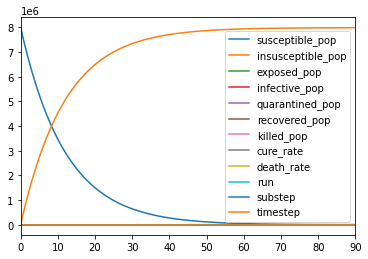

In [0]:
plt.figure(figsize=(15, 5))
data.plot()
plt.show()

In [0]:
data.tail(1)

,susceptible_pop,insusceptible_pop,exposed_pop,infective_pop,quarantined_pop,recovered_pop,killed_pop,cure_rate,death_rate,run,substep,timestep
90,4346.606314,7.981606e+06,0.003065,1.634169,240.12406,13488.94622,417.183904,0.069286,0.002143,1,1,90


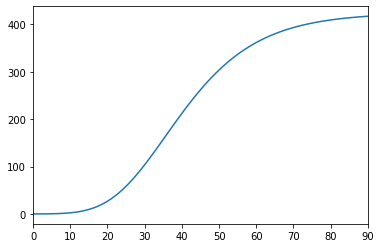

In [0]:
data.killed_pop.plot()